건강모니터링랩 ECG example 시각화 UI
작성자 : 이동우

Regular Expression 기반의 Parsing 코드

In [1]:
import re
anonymize_data = True
def parse(text):
    item_dict = {}
    data_strings = []
    text_before_data, data = text.split('data:')
    for match in re.finditer(r'(\w+):([^,]+)', text_before_data):
        key, value = match.groups()
        if "ObjectId" in value or "ISODate" in value:
            value = value.split('(')[1].split(')')[0].strip('\'"')
        item_dict[key] = value.strip().strip('\'"')

    if anonymize_data:
        if key == '_id':
            value = 'ObjectId(00000000)'
        elif key == 'pat_id':
            value = 'anonymous_user'
        elif key == 'editBy':
            value = 'user_editor'

    item_dict[key] = value.strip().strip('\'"')

    data = data[:-2]
    patterns = {
        'packetCount': r'packetCount:\s*([^,]+)',
        'heartRate': r'heartRate:\s*([^,]+)',
        'respirationRate': r'respirationRate:\s*([^,]+)',
        'temperature': r'temperature:\s*([^,]+)',
        'batteryPercentage': r'batteryPercentage:\s*([^,]+)',
        'motionStatus': r'motionStatus:\s*([^,]+)',
        'apnea': r'apnea:\s*([^,]+)',
        'leadFail': r'leadFail:\s*([^,]+)',
        'rhythmArrhythmiaInfo': r'rhythmArrhythmiaInfo:\s*([^,]+)',
        'beatArrhythmiaInfo': r'beatArrhythmiaInfo:\s*([^,]+)',
        'rPeak': r'rPeak:\s*([^,]+)',
        'ecg': r'ecg:\s*\[([^\]]+)]'
    }

    extracted_info = {}

    for field, pattern in patterns.items():
        matches = re.findall(pattern, text)
        if field == 'packetCount':
            extracted_info[field] = [int(match) for match in matches]
        elif field == 'ecg':
            extracted_info[field] = [[int(value) for value in match.split(',')] for match in matches]
        else:
            extracted_info[field] = matches

    grouped_data = {}
    for i, packet_count in enumerate(extracted_info['packetCount']):
        grouped_data[packet_count] = {field: extracted_info[field][i] for field in extracted_info if field != 'packetCount'}

    item_dict['data'] = grouped_data

    return item_dict

def read_text(file_path):
    try:
        with open(file_path, 'r') as file:
            file_contents = file.read()
        return file_contents
    except FileNotFoundError:
        print(f"파일을 찾을 수 없습니다: {file_path}")
        return None
    except Exception as e:
        print(f"파일 읽기 오류: {e}")
        return None



In [2]:
file_path = 'ecg_example.txt'
file_contents = read_text(file_path)
parsed_dict = parse(file_contents)

Pickle file 저장

In [3]:
import pickle
filename = 'parsed_data.pkl'

with open(filename, 'wb') as file:
    pickle.dump(parsed_dict, file)

print(f"Dictionary saved as '{filename}'")

Dictionary saved as 'parsed_data.pkl'


In [4]:
print(parsed_dict['data'].keys())

dict_keys([669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818])


Tkinter 기반 시각화 UI 구현
AFib 유무에 따라 ecg color가 변경됨.
부정맥 검출을 위해 'rhythmArrhythmiaInfo'와 'beatArrhythmiaInfo'의 논리합(OR)연산 값을 기준으로 color 변경

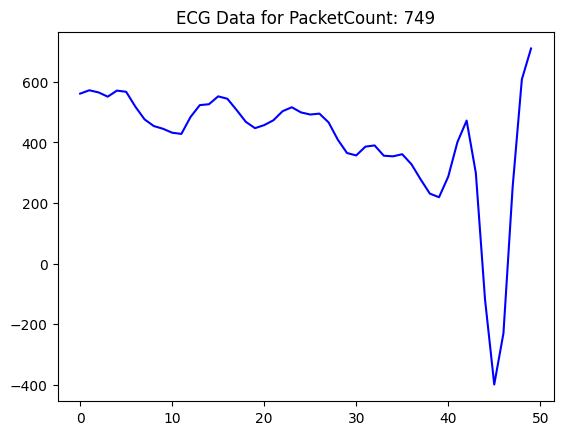

In [5]:
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt

def update_plot(packet_count=None):
    if packet_count is None:
        packet_count = int(packet_count_entry.get())

    data = parsed_dict['data'].get(packet_count, None)
    if data:
        
        r_AFib, b_AFib = False, False
        ecg_data = data['ecg']
        if data['rhythmArrhythmiaInfo'] != 'null' and data['rhythmArrhythmiaInfo'] != '13':
            r_AFib = True
        if data['beatArrhythmiaInfo'] != '0' :
            b_AFib = True

        AFib = r_AFib or b_AFib
        if AFib :
            clr = 'red'
        else :
            clr = 'blue'
        ax.clear()
        ax.plot(ecg_data, color = clr)
        ax.set_title(f'ECG Data for PacketCount: {packet_count}')
        canvas.draw()

        slider.set(packet_count)

        info_text = '\n'.join([f'{key}: {value}' for key, value in data.items() if key != 'ecg'])
        info_label.config(text=info_text)
    else:
        info_label.config(text="No data available for this packet count.")

root = tk.Tk()
root.title("ECG Data Visualization")

graph_frame = tk.Frame(root)
graph_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

fig, ax = plt.subplots()
canvas = FigureCanvasTkAgg(fig, master=graph_frame)
widget = canvas.get_tk_widget()
widget.pack(fill=tk.BOTH, expand=True)

info_input_frame = tk.Frame(root)
info_input_frame.pack(side=tk.RIGHT, fill=tk.Y)

info_label = tk.Label(info_input_frame, text="", justify=tk.LEFT)
info_label.pack(side=tk.TOP, fill=tk.X)

input_frame = tk.Frame(info_input_frame)
input_frame.pack(side=tk.TOP, fill=tk.X)

packet_count_entry = tk.Entry(input_frame, width=20) 
packet_count_entry.pack(side=tk.LEFT, fill=tk.X, expand=True)

update_button = tk.Button(input_frame, text="Update", command=lambda: update_plot())
update_button.pack(side=tk.LEFT)

packet_counts = list(parsed_dict['data'].keys())
slider = tk.Scale(info_input_frame, from_=min(packet_counts), to=max(packet_counts), orient=tk.HORIZONTAL, command=lambda v: update_plot(int(v)))
slider.pack(side=tk.TOP, fill=tk.X)

root.mainloop()